# Example 1 — Force Sampling RDF Calculation

### Welcome to revelsMD

Welcome to **revelsMD**, a one-stop shop for reduced-variance sampling using various techniques based on the use of force densities.  
We start by loading the critical libraries.

In [15]:
from revelsMD import *
from revelsMD.revels_rdf import *
from revelsMD.trajectory_states import LammpsTrajectoryState
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
%matplotlib inline

### Generating a Trajectory State

First, we generate a **TrajectoryState**.  
The trajectory state is a Python object that defines the necessary information about a trajectory required for parsing.  
**revelsMD** can operate on several different trajectory types, flexibly supporting core MD codes (**LAMMPS** and **GROMACS**), AIMD DFT codes (**VASP**), and a more customizable **NumPy-driven** version.  

To parse forces and positions from each of these codes, different parsers are used internally, and the **TrajectoryState** class allows this to be handled flexibly under the hood.

In [16]:
traj=LammpsTrajectoryState('../../../examples/example_1_LJ/dump.nh.lammps','../../../examples/example_1_LJ/data.fin.nh.data',units='lj',atom_style="id resid type q x y z ix iy iz")

Next, we feed this state into a run function.  
If you are using **LAMMPS** data (as in this example), you will need to specify whether you are using *lj*, *real*, or *metal* units.

## Calculating an rdf from infinity 

We can then run a **radial distribution function (RDF)** calculation using **revelsMD**.  
As described in [this paper](https://aip.scitation.org/doi/abs/10.1063/5.0053737), there are three available formulations:

1. Integrating the Heaviside function from infinity to zero  
2. Integrating from zero to infinity  
3. Using a linear combination of the two  

Here, we begin with the earliest formulation (from infinity), developed by Borgis.

In [17]:
RDF=RevelsRDF.run_rdf(traj,'1','1',1.35,period=1,delr=0.005,from_zero=False)

100%|██████████| 49/49 [03:05<00:00,  3.78s/it]


In [18]:
help(RevelsRDF.run_rdf)

Help on function run_rdf in module revelsMD.revels_rdf:

run_rdf(TS, atom_a: 'str', atom_b: 'str', temp: 'float', delr: 'float' = 0.01, start: 'int' = 0, stop: 'int' = -1, period: 'int' = 1, rmax: 'Union[bool, float]' = True, from_zero: 'bool' = True) -> 'Optional[np.ndarray]'
    Compute the force-weighted RDF across multiple frames.

    Parameters
    ----------
    TS : object
        Trajectory state (LAMMPS, MDAnalysis, VASP, or NumPy compatible).
    atom_a, atom_b : str
        Species identifiers. If identical, computes like-pair RDF.
    temp : float
        Temperature in Kelvin.
    delr : float, optional
        Bin spacing in distance (default: 0.01).
    start, stop : int, optional
        Frame range for averaging (default: 0 → -1).
    period : int, optional
        Frame stride (default: 1).
    rmax : bool or float, optional
        If True, use half-box length (or max half-dimension for LAMMPS);
        otherwise, set numeric cutoff.
    from_zero : bool, optional
 

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

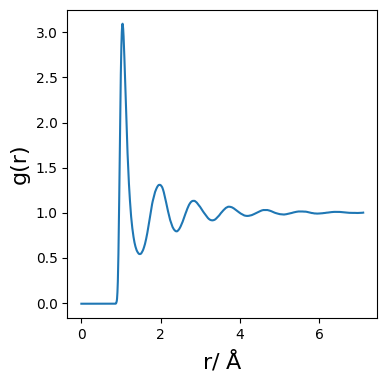

In [19]:
plt.figure(figsize=(4,4))
plt.plot(RDF[0,:],RDF[1,:])
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

One of the adventages of this family of methods is that a continuous if often noisy instantaneous (single frame) radial distribution function can be calculated. We can obtain this by setting the period to the number of frames in the the trajectory state.

In [20]:
RDF_instaneous=RevelsRDF.run_rdf(traj,'1','1',1.35,period=int(traj.frames),delr=0.005,from_zero=False)

100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

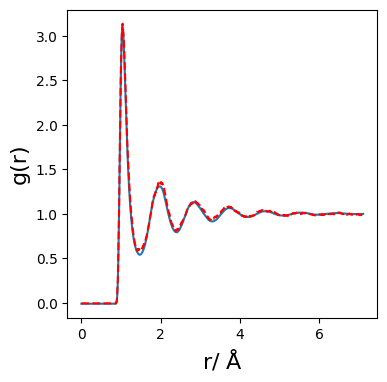

In [21]:
plt.figure(figsize=(4,4))
plt.plot(RDF[0,:],RDF[1,:])
plt.plot(RDF_instaneous[0,:],RDF_instaneous[1,:],color='red',linestyle='dashed')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

In this case, there is exceptional agreement.  
For systems with fewer particles or for solvated systems, the agreement will be worse.  
However, even when the graph appears visually unappealing, instantaneous calculations still have utility for determining instantaneous thermodynamic quantities.

## Calculating an rdf from zero 

Compared to conventional methodologies, force integration does not always recover both the zero and infinite limits simultaneously.  
There is therefore a choice between obtaining a small (often imperceptible) error at the zero limit or at large *r*.  

We choose to recover the zero limit correctly, enforcing \\( g(r) = 0 \\) as the default.  
This is because an infinite limit of \\( g(r) = 1 \\) is not strictly required, nor is it as unphysical as allowing overlap of particles at \\( r = 0 \\).

From the perspective of the code, this means that if `from_zero` is **not** set to `False`, the calculation will be performed with the Heaviside function taken from zero.


In [22]:
RDF_default=RevelsRDF.run_rdf(traj,'1','1',1.35,period=1,delr=0.005)

100%|██████████| 49/49 [03:12<00:00,  3.93s/it]


Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

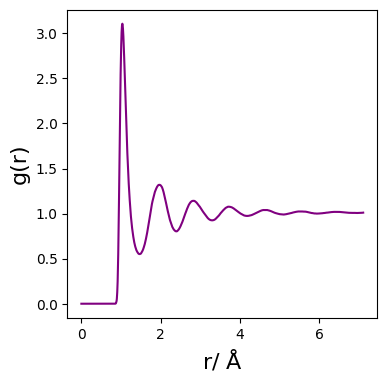

In [23]:
plt.figure(figsize=(4,4))
plt.plot(RDF_default[0,:],RDF_default[1,:],color='purple')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

## Using a linear combination of these terms

The **linear combination method**, described in the same [paper](https://aip.scitation.org/doi/abs/10.1063/5.0053737), eliminates the issue of incorrect limits by taking a weighted linear combination.  
This can be performed using the `run_rdf_lambda` function, which accepts the same inputs as the conventional RDF calculation.

In [24]:
RDF_lambda=RevelsRDF.run_rdf_lambda(traj,'1','1',1.35,period=1,delr=0.005)

100%|██████████| 49/49 [04:28<00:00,  5.48s/it]


The output of this function is a *(number of bins) × 3* array, where:

- The first column contains the bin centers  
- The second column contains the refined \\( g(r) \\) values  
- The third column contains the linear combination term described in the paper  

For this example, the RDF is indistinguishable from the previous calculation given the number of particles, but the limits are now correctly enforced.

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

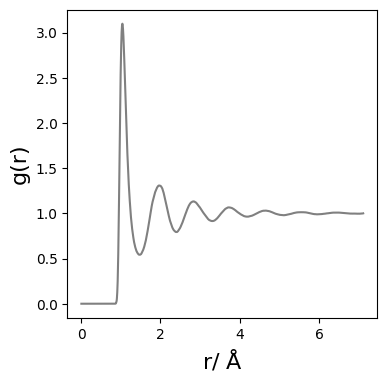

In [25]:
plt.figure(figsize=(4,4))
plt.plot(RDF_lambda[:,0],RDF_lambda[:,1],color='grey')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

The linear combination corresponding to that RDF is shown below.  
Its form will vary between systems, but it will always approach **1 at \\( r = 0 \\)** and **0 at \\( r = \infty \\)**.  
As a general rule, the value is typically close to zero at intermediate distances as the first peak contributes most strongly to the variance.

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

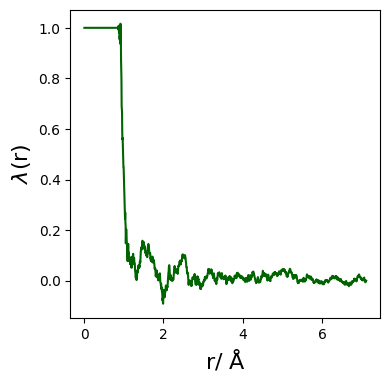

In [26]:
plt.figure(figsize=(4,4))
plt.plot(RDF_lambda[:,0],RDF_lambda[:,2],color='darkGreen')
plt.ylabel(r'$\lambda$(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)